<a href="https://colab.research.google.com/github/viditkhemka63/Recommended-System/blob/master/Recommended_System_on_Netflix_Prize_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommended System on Netflix Prize dataset

![Movie Recommender System](https://cdn-images-1.medium.com/max/1200/1*PsI17WdbeL1OUyhD5H6JMQ.png)

# Getting data from kaggle 

In [0]:
! pip install -q kaggle

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vidit64","key":"97e40619934731fe29f37d3ed18dd5e6"}'}

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
 ! kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
new-york-state/nys-environmental-remediation-sites          NYS Environmental Remediation Sites                   3MB  2019-07-23 08:22:57            533  
new-york-city/new-york-city-current-job-postings            New York City Current Job Postings                    3MB  2019-07-21 22:04:51           3824  
AnalyzeBoston/crimes-in-boston                              Crimes in Boston                                     10MB  2018-09-04 17:56:03           3380  
jealousleopard/goodreadsbooks                               Goodreads-books                                     632KB  2019-06-14 16:35:05           4257  
sudalairajkumar/chennai-water-management                    Chen

In [6]:
!kaggle datasets download  'netflix-inc/netflix-prize-data'

 98% 667M/682M [00:11<00:00, 60.9MB/s]
100% 682M/682M [00:11<00:00, 60.2MB/s]


In [0]:
!wget https://archive.org/download/nf_prize_dataset.tar/nf_prize_dataset.tar.gz

In [8]:
!pwd

/content


In [9]:
!unzip netflix-prize-data.zip

Archive:  netflix-prize-data.zip
  inflating: README                  
  inflating: combined_data_1.txt     
  inflating: combined_data_2.txt     
  inflating: combined_data_3.txt     
  inflating: combined_data_4.txt     
  inflating: movie_titles.csv        
  inflating: probe.txt               
  inflating: qualifying.txt          


In [11]:
!pip install surprise

     |████████████████████████████████| 3.3MB 6.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, evaluate
sns.set_style("darkgrid")

In [13]:
df = pd.read_csv('combined_data_1.txt', header = None, names = ['Cust_Id', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)

print('Dataset 1 shape: {}'.format(df.shape))
print('-Dataset examples-')
print(df.iloc[::5000000, :])

Dataset 1 shape: (24058263, 2)
-Dataset examples-
          Cust_Id  Rating
0              1:     NaN
5000000   2560324     4.0
10000000  2271935     2.0
15000000  1921803     2.0
20000000  1933327     3.0


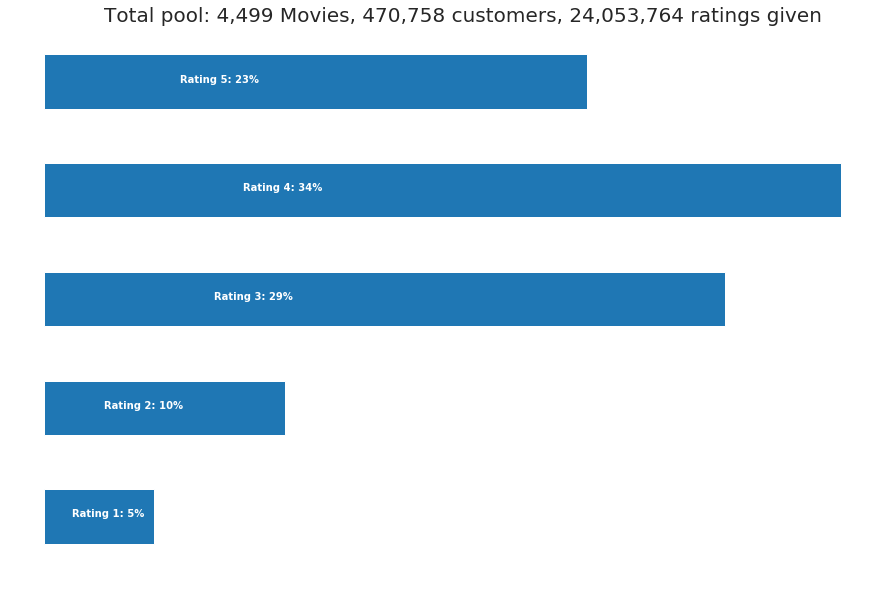

In [15]:
p = df.groupby('Rating')['Rating'].agg(['count'])


# Get movies count
movie_count = df.isnull().sum()[1]

# Get customer count 
cust_count = df['Cust_Id'].nunique() - movie_count

# Get rating count
rating_count = df['Cust_Id'].count() - movie_count

ax = p.plot(kind = 'barh', legend = False, figsize = (15,10))
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(movie_count, cust_count, rating_count), fontsize=20)
plt.axis('off')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')

# Data Cleaning

In [16]:
df_nan = pd.DataFrame(pd.isnull(df['Rating']))
df_nan = df_nan[df_nan['Rating'] == True]
df_nan = df_nan.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_nan['index'][1:], df_nan['index'][:-1]):
    temp = np.full((1, i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1

last_record = np.full((1,len(df) - df_nan.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Movie Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Movie Length: 24053764


In [17]:
df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Cust_Id'] = df['Cust_Id'].astype(int)
print('Dataset example')
df.head(10)

Dataset example


,Cust_Id,Rating,Movie_Id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1
6,893988,3.0,1
7,124105,4.0,1
8,1248029,3.0,1
9,1842128,4.0,1
10,2238063,3.0,1


In [18]:
print( df['Movie_Id'].unique().sum() )

10122750


#  Data slicing

In [20]:
f = ['count', 'mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index
print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Cust_Id')['Rating'].agg(f)
df_cust_summary_index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8), 0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index
print('Customer minimum times of review: {}'.format(cust_benchmark))


Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


In [21]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Cust_Id'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Cust_Id  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


In [22]:
df.head()

,Cust_Id,Rating,Movie_Id
5109,785314,1.0,8
5110,243963,3.0,8
5112,1447783,4.0,8
5116,1912665,1.0,8
5119,1744889,1.0,8


In [23]:
df_p = pd.pivot_table(df,values='Rating',index='Cust_Id',columns='Movie_Id')

print(df_p.shape)

(95325, 900)


In [24]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1", header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# Recommend with Collaborative Filtering

In [25]:
reader = Reader()

# get just top 100K rows for faster run time
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']][:100000], reader)
data.split(n_folds=3)

svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])


/usr/local/lib/python3.6/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python3.6/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9884
MAE:  0.7977
------------
Fold 2
RMSE: 0.9869
MAE:  0.7979
------------
Fold 3
RMSE: 0.9808
MAE:  0.7862
------------
------------
Mean RMSE: 0.9854
Mean MAE : 0.7939
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7977155123970434,
                             0.7978963662354291,
                             0.7862053587964166],
                            'rmse': [0.9884439254104491,
                             0.9868502320875713,
                             0.9808469956189437]})

In [26]:
df_785314 = df[(df['Cust_Id'] == 785314) & (df['Rating'] == 5)]
df_785314 = df_785314.set_index('Movie_Id')
df_785314 = df_785314.join(df_title)['Name']
print(df_785314)

Movie_Id
175                                        Reservoir Dogs
311                                               Ed Wood
329                                                 Dogma
331                                           Chasing Amy
788                                                Clerks
798                                                  Jaws
907                                       Animal Crackers
985                                             The Mummy
1552                                          Black Adder
1905    Pirates of the Caribbean: The Curse of the Bla...
2000                          Four Weddings and a Funeral
2122                                 Being John Malkovich
2342                                        Super Size Me
2360                                  Singin' in the Rain
2430                           Alien: Collector's Edition
2443                             Like Water for Chocolate
2452        Lord of the Rings: The Fellowship of the Ring
2465 

In [30]:
user_785314 = df_title.copy()
user_785314 = user_785314.reset_index()
user_785314 = user_785314[~user_785314['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data = Dataset.load_from_df(df[['Cust_Id', 'Movie_Id', 'Rating']], reader)

print('Built data')
trainset = data.build_full_trainset()
print('Training')
svd.train(trainset)

print('Predicting')

user_785314['Estimate_Score'] = user_785314['Movie_Id'].apply(lambda x: svd.predict(785314, x).est)

user_785314 = user_785314.drop('Movie_Id', axis = 1)

user_785314 = user_785314.sort_values('Estimate_Score', ascending=False)
print(user_785314.head(10))

Built data
Training


/usr/local/lib/python3.6/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


Predicting
        Year                                   Name  Estimate_Score
4114  1999.0                The Simpsons: Bart Wars        5.000000
2171  1991.0                 The Simpsons: Season 3        5.000000
1019  1989.0                 The Simpsons: Season 1        5.000000
3045  1990.0      The Simpsons: Treehouse of Horror        5.000000
2101  1994.0                 The Simpsons: Season 6        5.000000
2056  2001.0     Buffy the Vampire Slayer: Season 6        4.956055
328   1999.0                                  Dogma        4.956019
3167  1987.0              Evil Dead 2: Dead by Dawn        4.937348
1799  2002.0            An Evening With Kevin Smith        4.831588
3443  2004.0  Family Guy: Freakin' Sweet Collection        4.790896


# Recommend with Pearsons' R correlations

In [0]:
def recommend(movie_title, min_count):
    print("For movie ({})".format(movie_title))
    print("- Top 10 movies recommended based on Pearsons'R correlation - ")
    i = int(df_title.index[df_title['Name'] == movie_title][0])
    target = df_p[i]
    similar_to_target = df_p.corrwith(target)
    corr_target = pd.DataFrame(similar_to_target, columns = ['PearsonR'])
    corr_target.dropna(inplace = True)
    corr_target = corr_target.sort_values('PearsonR', ascending = False)
    corr_target.index = corr_target.index.map(int)
    corr_target = corr_target.join(df_title).join(df_movie_summary)[['PearsonR', 'Name', 'count', 'mean']]
    print(corr_target[corr_target['count']>min_count][:10].to_string(index=False))

In [58]:
recommend("The Matrix: Revolutions", 0)

For movie (The Matrix: Revolutions)
- Top 10 movies recommended based on Pearsons'R correlation - 
 PearsonR                                      Name   count      mean
 1.000000                   The Matrix: Revolutions   60415  3.517040
 0.718287                      The Matrix: Reloaded  106807  3.514704
 0.384310                                Species II    7526  2.781424
 0.378696                            Blade: Trinity   42727  3.548974
 0.377859                            Chain Reaction   15966  3.188150
 0.374141          Superman IV: The Quest for Peace    7532  2.761020
 0.361900                                   Rocky V    8170  3.033660
 0.351280  Alien: Resurrection: Collector's Edition   15828  3.475550
 0.348885                                     Congo   13598  2.852772
 0.346299         Final Fantasy: The Spirits Within   17691  3.341303
